# 날씨(온도, 습도)가 화재 발생 횟수와 상관관계가 있는지

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

# 경고 무시
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

In [9]:
df_fire = pd.read_csv('./filtered_data/2023_일별_화재건수.csv')
df_weather = pd.read_csv('./filtered_data/seoul_daily_avg_humidity.csv')

In [6]:
df_weather.isna().sum()

날짜              0
서울시_평균_습도(%)    0
서울시_평균_온도       0
dtype: int64

In [10]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# 데이터 확인
print("화재 데이터 (2023_일별_화재건수.csv):")
print(df_fire.head())
print(f"Shape: {df_fire.shape}")
print(f"Columns: {df_fire.columns.tolist()}\n")

print("날씨 데이터 (seoul_daily_avg_humidity.csv):")
print(df_weather.head())
print(f"Shape: {df_weather.shape}")
print(f"Columns: {df_weather.columns.tolist()}")

화재 데이터 (2023_일별_화재건수.csv):
         날짜  발생횟수
0  20230101    17
1  20230102    19
2  20230103    17
3  20230104    24
4  20230105    17
Shape: (365, 2)
Columns: ['날짜', '발생횟수']

날씨 데이터 (seoul_daily_avg_humidity.csv):
           날짜  서울시_평균_습도(%)  서울시_평균_온도
0  2023-01-01     49.108729   1.026143
1  2023-01-02     38.333514  -2.949911
2  2023-01-03     41.334247  -3.126817
3  2023-01-04     43.641896  -0.391264
4  2023-01-05     51.527174  -0.190130
Shape: (360, 3)
Columns: ['날짜', '서울시_평균_습도(%)', '서울시_평균_온도']


In [11]:
# 2023년 전체 날짜 범위 생성 (1월 1일 ~ 12월 31일)
date_range_full = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
print(f"2023년 전체 날짜 수: {len(date_range_full)}일\n")

# df_weather의 날짜 컬럼 식별 및 파싱
# 날짜 컬럼명 찾기
date_cols = [col for col in df_weather.columns if 'date' in col.lower() or 'day' in col.lower() or col.startswith('20')]
print(f"날짜 컬럼 후보: {date_cols}")

# 첫 번째 객체 타입 컬럼을 날짜로 간주 (또는 명시적으로 지정)
if len(date_cols) > 0:
    date_col = date_cols[0]
else:
    # 첫 번째 컬럼이 날짜라고 가정
    date_col = df_weather.columns[0]

print(f"사용할 날짜 컬럼: '{date_col}'\n")

# 날짜 파싱
df_weather['date_parsed'] = pd.to_datetime(df_weather[date_col], errors='coerce')

# 파싱 실패 행 확인
failed_parse = df_weather[df_weather['date_parsed'].isna()].shape[0]
if failed_parse > 0:
    print(f"⚠️  날짜 파싱 실패한 행: {failed_parse}개")
    print(df_weather[df_weather['date_parsed'].isna()].head())
else:
    print("✓ 모든 날짜 파싱 성공\n")

# 데이터에 있는 날짜들
dates_in_data = set(df_weather['date_parsed'].dt.date)
dates_in_range = set(date_range_full.date)

# 누락된 날짜 찾기
missing_dates = sorted(dates_in_range - dates_in_data)
extra_dates = sorted(dates_in_data - dates_in_range)

print(f"데이터에 있는 날짜 수: {len(dates_in_data)}개")
print(f"2023년 전체 날짜 수: {len(dates_in_range)}개")
print(f"누락된 날짜 수: {len(missing_dates)}개\n")

if len(extra_dates) > 0:
    print(f"⚠️  2023년 범위 밖의 날짜: {len(extra_dates)}개")
    print(f"예시: {extra_dates[:5]}\n")

# 누락된 날짜 출력
if len(missing_dates) > 0:
    print("="*60)
    print(f"누락된 날짜 ({len(missing_dates)}개):")
    print("="*60)
    for i, missing_date in enumerate(missing_dates, 1):
        # 요일 계산
        day_of_week = pd.Timestamp(missing_date).day_name()
        day_names = {'Monday': '월요일', 'Tuesday': '화요일', 'Wednesday': '수요일',
                     'Thursday': '목요일', 'Friday': '금요일', 'Saturday': '토요일', 'Sunday': '일요일'}
        day_kr = day_names.get(day_of_week, day_of_week)
        print(f"{i:3d}. {missing_date} ({day_kr})")
else:
    print("✓ 누락된 날짜 없음 - 완전한 365일 데이터")

# 누락된 날짜를 CSV로 저장
missing_df = pd.DataFrame({
    'missing_date': missing_dates,
    'day_of_week': [pd.Timestamp(d).day_name() for d in missing_dates],
    'month': [pd.Timestamp(d).month for d in missing_dates],
    'day': [pd.Timestamp(d).day for d in missing_dates]
})

if len(missing_df) > 0:
    missing_df.to_csv('./filtered_data/weather_missing_dates.csv', index=False, encoding='utf-8')
    print(f"\n✓ 누락된 날짜를 저장: ./filtered_data/weather_missing_dates.csv")
    
    # 월별 누락 현황
    print("\n" + "="*60)
    print("월별 누락된 날짜 수:")
    print("="*60)
    month_names = {1:'1월', 2:'2월', 3:'3월', 4:'4월', 5:'5월', 6:'6월',
                   7:'7월', 8:'8월', 9:'9월', 10:'10월', 11:'11월', 12:'12월'}
    for month in range(1, 13):
        count = len(missing_df[missing_df['month'] == month])
        if count > 0:
            print(f"{month_names[month]}: {count}일 누락")
else:
    print("\n✓ 누락된 날짜가 없습니다!")

2023년 전체 날짜 수: 365일

날짜 컬럼 후보: []
사용할 날짜 컬럼: '날짜'

✓ 모든 날짜 파싱 성공

데이터에 있는 날짜 수: 360개
2023년 전체 날짜 수: 365개
누락된 날짜 수: 12개

⚠️  2023년 범위 밖의 날짜: 7개
예시: [datetime.date(2024, 1, 1), datetime.date(2024, 1, 2), datetime.date(2024, 1, 3), datetime.date(2024, 1, 4), datetime.date(2024, 1, 5)]

누락된 날짜 (12개):
  1. 2023-02-01 (수요일)
  2. 2023-02-21 (화요일)
  3. 2023-03-01 (수요일)
  4. 2023-03-04 (토요일)
  5. 2023-03-05 (일요일)
  6. 2023-03-11 (토요일)
  7. 2023-03-12 (일요일)
  8. 2023-03-13 (월요일)
  9. 2023-03-18 (토요일)
 10. 2023-03-19 (일요일)
 11. 2023-07-15 (토요일)
 12. 2023-10-23 (월요일)

✓ 누락된 날짜를 저장: ./filtered_data/weather_missing_dates.csv

월별 누락된 날짜 수:
2월: 2일 누락
3월: 8일 누락
7월: 1일 누락
10월: 1일 누락


✓ 시각화 저장: ./results/weather_missing_dates_analysis.png



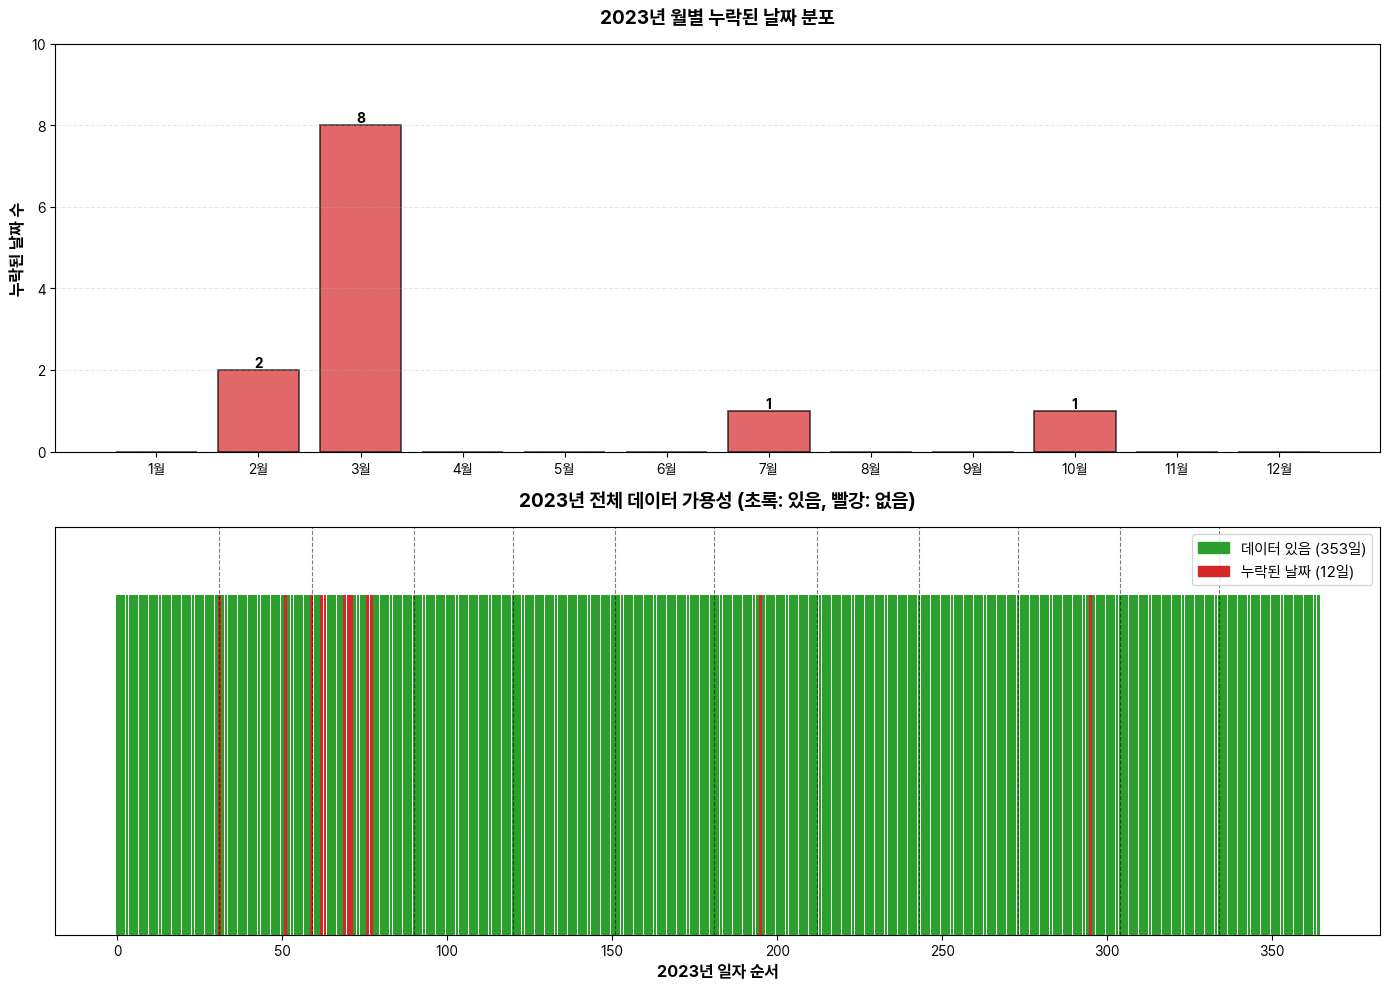

요약 통계
전체 365일 중 353일 (데이터 있음)
전체 365일 중 12일 (누락)
데이터 완성도: 96.7%

가장 많이 누락된 월: 3월 (8일)


In [12]:
# 시각화: 누락된 날짜 분포
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# 1. 월별 누락된 날짜 현황 (막대 그래프)
ax1 = axes[0]
month_missing = missing_df['month'].value_counts().sort_index()
months = range(1, 13)
month_counts = [month_missing.get(m, 0) for m in months]
month_names_kr = ['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월']

colors = ['#d62728' if c > 0 else '#1f77b4' for c in month_counts]
bars = ax1.bar(month_names_kr, month_counts, color=colors, alpha=0.7, edgecolor='black', linewidth=1.2)

ax1.set_ylabel('누락된 날짜 수', fontsize=12, fontweight='bold')
ax1.set_title('2023년 월별 누락된 날짜 분포', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylim(0, max(month_counts) + 2 if max(month_counts) > 0 else 2)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# 각 막대에 숫자 표시
for bar, count in zip(bars, month_counts):
    if count > 0:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(count)}',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

# 2. 2023년 캘린더 형식 히트맵 (월별로 날짜 표시)
ax2 = axes[1]

# 데이터에 있는 날짜와 없는 날짜 마킹
dates_present = []
dates_missing = []
for d in date_range_full:
    if d.date() in dates_in_data:
        dates_present.append(d)
    else:
        dates_missing.append(d)

# 월별로 그룹화하여 시각화
month_ranges = []
for month in range(1, 13):
    dates_in_month = [d for d in date_range_full if d.month == month]
    if dates_in_month:
        month_ranges.append((month_names_kr[month-1], dates_in_month))

# 선형 캘린더 뷰 (일별 상태)
all_dates_list = list(date_range_full)
present_missing = [1 if d.date() in dates_in_data else 0 for d in all_dates_list]

x_pos = range(len(all_dates_list))
colors_cal = ['#2ca02c' if v else '#d62728' for v in present_missing]
ax2.bar(x_pos, [1]*len(all_dates_list), color=colors_cal, width=0.9, edgecolor='none')

ax2.set_ylabel('')
ax2.set_xlabel('2023년 일자 순서', fontsize=12, fontweight='bold')
ax2.set_title('2023년 전체 데이터 가용성 (초록: 있음, 빨강: 없음)', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylim(0, 1.2)
ax2.set_yticks([])

# 범례
present_patch = mpatches.Patch(color='#2ca02c', label=f'데이터 있음 ({len(dates_present)}일)')
missing_patch = mpatches.Patch(color='#d62728', label=f'누락된 날짜 ({len(dates_missing)}일)')
ax2.legend(handles=[present_patch, missing_patch], loc='upper right', fontsize=11)

# x축 라벨 (월별)
month_starts = [0]
for i, d in enumerate(all_dates_list):
    if d.day == 1 and d.month != 1:
        month_starts.append(i)
month_starts.append(len(all_dates_list))

# 월 구분선 그리기
for ms in month_starts[1:-1]:
    ax2.axvline(x=ms, color='black', linestyle='--', alpha=0.5, linewidth=0.8)

plt.tight_layout()
plt.savefig('./results/weather_missing_dates_analysis.png', dpi=300, bbox_inches='tight')
print("✓ 시각화 저장: ./results/weather_missing_dates_analysis.png\n")
plt.show()

# 요약 통계
print("="*60)
print("요약 통계")
print("="*60)
print(f"전체 365일 중 {len(dates_present)}일 (데이터 있음)")
print(f"전체 365일 중 {len(dates_missing)}일 (누락)")
print(f"데이터 완성도: {len(dates_present)/365*100:.1f}%")
print(f"\n가장 많이 누락된 월: 3월 ({len(missing_df[missing_df['month'] == 3])}일)")

날씨 데이터 보간 시작

원본 데이터: 360일
누락된 날짜: 12일

보간 전 NaN 개수:
  습도: 12개
  온도: 12개

보간 후 NaN 개수:
  습도: 0개
  온도: 0개

보간 후 데이터: 365일 (완전한 365일)

보간된 데이터 샘플 (3월 누락 주변):
----------------------------------------------------------------------
        날짜  서울시_평균_습도(%)  서울시_평균_온도
2023-02-28     53.824700   4.123024
2023-03-01     45.115899   4.029116
2023-03-02     36.407098   3.935209
2023-03-03     54.356336   3.563935
2023-03-04     46.809766   6.595855
2023-03-05     39.263196   9.627774
2023-03-06     31.716626  12.659693

✓ 보간된 완전한 데이터 저장: ./filtered_data/seoul_daily_avg_weather_interpolated_365.csv
✓ 보간 비교 시각화 저장: ./results/weather_interpolation_comparison.png

✓ 보간 비교 시각화 저장: ./results/weather_interpolation_comparison.png



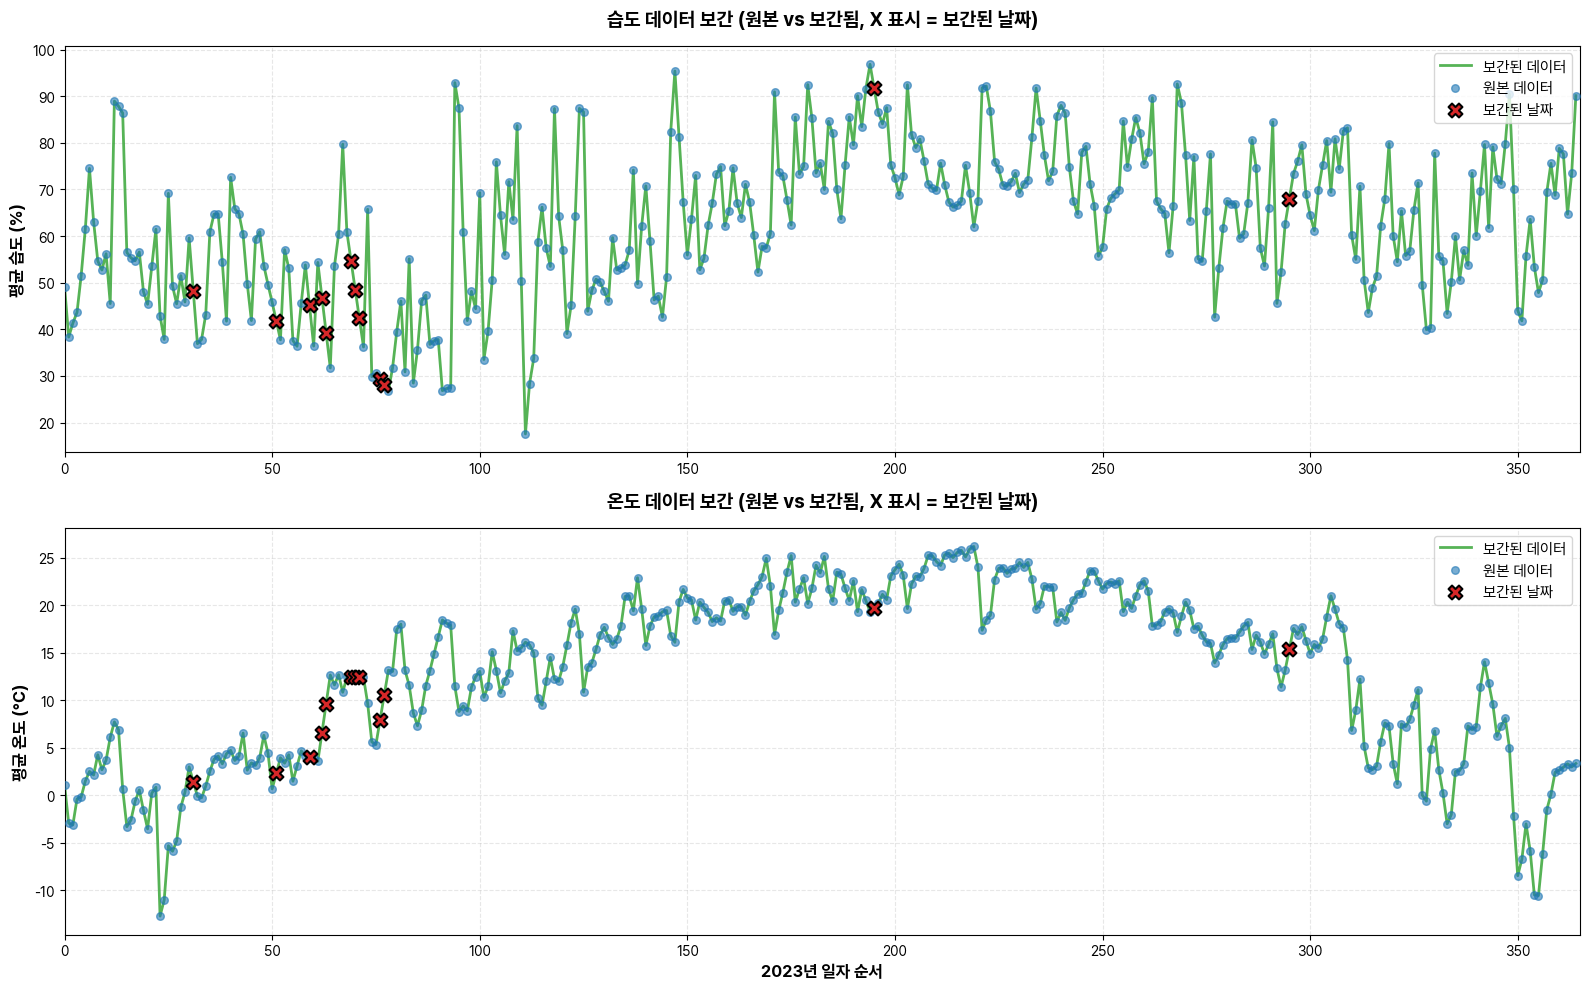

보간된 데이터 통계

습도 (%)
  평균: 62.76
  최소: 17.56
  최대: 96.85
  표준편차: 16.03

온도 (°C)
  평균: 13.08
  최소: -12.74
  최대: 26.20
  표준편차: 8.74

✓ 보간 완료! 이제 화재 데이터와 병합할 준비가 되었습니다.


In [14]:
# 날씨 데이터 보간 (누락된 12일)
import pandas as pd
import numpy as np

print("="*70)
print("날씨 데이터 보간 시작")
print("="*70)

# 현재 데이터 확인
print(f"\n원본 데이터: {len(df_weather)}일")
print(f"누락된 날짜: {len(missing_dates)}일")

# 보간 전 데이터 정렬 및 준비
df_weather_sorted = df_weather[['날짜', '서울시_평균_습도(%)', '서울시_평균_온도']].copy()
df_weather_sorted['date_parsed'] = pd.to_datetime(df_weather_sorted['날짜'])
df_weather_sorted = df_weather_sorted.sort_values('date_parsed').reset_index(drop=True)

# 2023년 전체 날짜 범위에 대한 DataFrame 생성
date_range_2023 = pd.date_range(start='2023-01-01', end='2023-12-31', freq='D')
df_full_dates = pd.DataFrame({'date': date_range_2023})

# 원본 데이터 병합 (누락된 날짜는 NaN)
df_weather_sorted['date'] = df_weather_sorted['date_parsed'].dt.date
df_weather_sorted['date'] = pd.to_datetime(df_weather_sorted['date'])

df_merged = df_full_dates.merge(
    df_weather_sorted[['date', '서울시_평균_습도(%)', '서울시_평균_온도']],
    left_on='date',
    right_on='date',
    how='left'
)

# 보간 전 누락 현황
print(f"\n보간 전 NaN 개수:")
print(f"  습도: {df_merged['서울시_평균_습도(%)'].isna().sum()}개")
print(f"  온도: {df_merged['서울시_평균_온도'].isna().sum()}개")

# 선형 보간 (Linear Interpolation)
# 선택지: 'linear' (선형), 'spline' (스플라인), 'nearest' (최근접값)
df_merged['서울시_평균_습도(%)'] = df_merged['서울시_평균_습도(%)'].interpolate(method='linear')
df_merged['서울시_평균_온도'] = df_merged['서울시_평균_온도'].interpolate(method='linear')

# 경계값 처리 (첫/마지막 NaN이 있을 경우 forward fill)
df_merged['서울시_평균_습도(%)'] = df_merged['서울시_평균_습도(%)'].fillna(method='bfill').fillna(method='ffill')
df_merged['서울시_평균_온도'] = df_merged['서울시_평균_온도'].fillna(method='bfill').fillna(method='ffill')

# 보간 후 정리
df_weather_interpolated = df_merged[['date', '서울시_평균_습도(%)', '서울시_평균_온도']].copy()
df_weather_interpolated['날짜'] = df_weather_interpolated['date'].astype(str)
df_weather_final = df_weather_interpolated[['날짜', '서울시_평균_습도(%)', '서울시_평균_온도']].reset_index(drop=True)

print(f"\n보간 후 NaN 개수:")
print(f"  습도: {df_weather_final['서울시_평균_습도(%)'].isna().sum()}개")
print(f"  온도: {df_weather_final['서울시_평균_온도'].isna().sum()}개")

print(f"\n보간 후 데이터: {len(df_weather_final)}일 (완전한 365일)")

# 보간된 데이터 샘플 확인 (누락된 날짜 주변)
print("\n보간된 데이터 샘플 (3월 누락 주변):")
print("-"*70)
march_data = df_weather_final[
    (df_weather_final['날짜'] >= '2023-02-28') & 
    (df_weather_final['날짜'] <= '2023-03-06')
]
print(march_data.to_string(index=False))

# 보간된 데이터 저장
df_weather_final.to_csv('./filtered_data/seoul_daily_avg_weather_interpolated_365.csv', 
                         index=False, encoding='utf-8')
print(f"\n✓ 보간된 완전한 데이터 저장: ./filtered_data/seoul_daily_avg_weather_interpolated_365.csv")

# 보간 전후 비교 시각화
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# 습도 비교
ax1 = axes[0]
ax1.plot(range(len(df_weather_final)), df_weather_final['서울시_평균_습도(%)'], 
         label='보간된 데이터', linewidth=2, color='#2ca02c', alpha=0.8)

# 원본 데이터 포인트 표시
original_dates_set = set(df_weather_sorted['date_parsed'].dt.date)
original_indices = []
for i, date_str in enumerate(df_weather_final['날짜']):
    date_obj = pd.to_datetime(date_str).date()
    if date_obj in original_dates_set:
        original_indices.append(i)

if original_indices:
    ax1.scatter(original_indices, 
               [df_weather_final.iloc[i]['서울시_평균_습도(%)'] for i in original_indices],
               label='원본 데이터', s=30, color='#1f77b4', alpha=0.6, zorder=5)

# 누락된 날짜 표시
missing_indices = []
for missing_date in missing_dates:
    for i, date_str in enumerate(df_weather_final['날짜']):
        if pd.to_datetime(date_str).date() == missing_date:
            missing_indices.append(i)
            break

if missing_indices:
    ax1.scatter(missing_indices, 
               [df_weather_final.iloc[i]['서울시_평균_습도(%)'] for i in missing_indices],
               s=100, color='#d62728', marker='X', zorder=10, edgecolors='black', linewidth=1.5,
               label='보간된 날짜')

ax1.set_ylabel('평균 습도 (%)', fontsize=12, fontweight='bold')
ax1.set_title('습도 데이터 보간 (원본 vs 보간됨, X 표시 = 보간된 날짜)', fontsize=14, fontweight='bold', pad=15)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(fontsize=11, loc='upper right')
ax1.set_xlim(0, 365)

# 온도 비교
ax2 = axes[1]
ax2.plot(range(len(df_weather_final)), df_weather_final['서울시_평균_온도'], 
         label='보간된 데이터', linewidth=2, color='#2ca02c', alpha=0.8)

if original_indices:
    ax2.scatter(original_indices,
               [df_weather_final.iloc[i]['서울시_평균_온도'] for i in original_indices],
               label='원본 데이터', s=30, color='#1f77b4', alpha=0.6, zorder=5)

if missing_indices:
    ax2.scatter(missing_indices, 
               [df_weather_final.iloc[i]['서울시_평균_온도'] for i in missing_indices],
               s=100, color='#d62728', marker='X', zorder=10, edgecolors='black', linewidth=1.5,
               label='보간된 날짜')

ax2.set_xlabel('2023년 일자 순서', fontsize=12, fontweight='bold')
ax2.set_ylabel('평균 온도 (°C)', fontsize=12, fontweight='bold')
ax2.set_title('온도 데이터 보간 (원본 vs 보간됨, X 표시 = 보간된 날짜)', fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, linestyle='--')
ax2.legend(fontsize=11, loc='upper right')
ax2.set_xlim(0, 365)

plt.tight_layout()
plt.savefig('./results/weather_interpolation_comparison.png', dpi=300, bbox_inches='tight')
print("✓ 보간 비교 시각화 저장: ./results/weather_interpolation_comparison.png\n")
plt.show()

# 보간된 데이터 통계
print("="*70)
print("보간된 데이터 통계")
print("="*70)
print(f"\n습도 (%)")
print(f"  평균: {df_weather_final['서울시_평균_습도(%)'].mean():.2f}")
print(f"  최소: {df_weather_final['서울시_평균_습도(%)'].min():.2f}")
print(f"  최대: {df_weather_final['서울시_평균_습도(%)'].max():.2f}")
print(f"  표준편차: {df_weather_final['서울시_평균_습도(%)'].std():.2f}")

print(f"\n온도 (°C)")
print(f"  평균: {df_weather_final['서울시_평균_온도'].mean():.2f}")
print(f"  최소: {df_weather_final['서울시_평균_온도'].min():.2f}")
print(f"  최대: {df_weather_final['서울시_평균_온도'].max():.2f}")
print(f"  표준편차: {df_weather_final['서울시_평균_온도'].std():.2f}")

print("\n" + "="*70)
print("✓ 보간 완료! 이제 화재 데이터와 병합할 준비가 되었습니다.")
print("="*70)

In [16]:
# 화재 데이터와 날씨 데이터 병합 (일자 기준)
import pandas as pd
import numpy as np

print("="*70)
print("화재 데이터와 날씨 데이터 병합")
print("="*70)

# 보간된 날씨 데이터 로드
df_weather_final = pd.read_csv('./filtered_data/seoul_daily_avg_weather_interpolated_365.csv', 
                                encoding='utf-8')

print(f"\n원본 데이터:")
print(f"  화재 데이터: {len(df_fire)}일")
print(f"  날씨 데이터: {len(df_weather_final)}일")

# 데이터 확인
print(f"\n화재 데이터 형식:")
print(df_fire.head())
print(f"\n날씨 데이터 형식:")
print(df_weather_final.head())

# 날짜 컬럼 정규화
# 화재 데이터: '날짜' 컬럼이 YYYYMMDD 형식 (예: 20230101)
# 날씨 데이터: '날짜' 컬럼이 YYYY-MM-DD 형식 (예: 2023-01-01)

# 화재 데이터 날짜 변환
df_fire_prep = df_fire.copy()
df_fire_prep['날짜_formatted'] = pd.to_datetime(df_fire_prep['날짜'], format='%Y%m%d').astype(str)

# 날씨 데이터 날짜 변환
df_weather_prep = df_weather_final.copy()
df_weather_prep['날짜_formatted'] = pd.to_datetime(df_weather_prep['날짜']).astype(str)

print(f"\n정규화된 날짜 샘플:")
print(f"  화재: {df_fire_prep['날짜_formatted'].head(3).tolist()}")
print(f"  날씨: {df_weather_prep['날짜_formatted'].head(3).tolist()}")

# 일자 기준으로 병합 (inner join)
df_merged = df_fire_prep.merge(
    df_weather_prep[['날짜_formatted', '서울시_평균_습도(%)', '서울시_평균_온도']],
    left_on='날짜_formatted',
    right_on='날짜_formatted',
    how='inner'
)

# 필요한 컬럼만 정리
df_merged_final = df_merged[['날짜', '발생횟수', '서울시_평균_습도(%)', '서울시_평균_온도']].copy()
df_merged_final = df_merged_final.rename(columns={
    '날짜': '날짜(YYYYMMDD)',
    '발생횟수': '화재_건수',
    '서울시_평균_습도(%)': '습도(%)',
    '서울시_평균_온도': '온도(℃)'
})

# 날짜 형식 추가 (읽기 편하도록)
df_merged_final['날짜_읽기용'] = pd.to_datetime(df_merged_final['날짜(YYYYMMDD)'], format='%Y%m%d').astype(str)

print(f"\n병합 결과:")
print(f"  병합된 행 수: {len(df_merged_final)}일")
print(f"  컬럼: {df_merged_final.columns.tolist()}")

# 데이터 확인
print(f"\n병합된 데이터 샘플 (처음 10일):")
print("-"*70)
print(df_merged_final.head(10).to_string(index=False))

print(f"\n병합된 데이터 샘플 (마지막 10일):")
print("-"*70)
print(df_merged_final.tail(10).to_string(index=False))

# 병합 결과 저장
df_merged_final.to_csv('./filtered_data/fire_weather_merged_365.csv', 
                       index=False, encoding='utf-8')
print(f"\n✓ 병합 데이터 저장: ./filtered_data/fire_weather_merged_365.csv")

# 기본 통계
print("\n" + "="*70)
print("병합 데이터 통계")
print("="*70)
print(f"\n화재 건수:")
print(f"  평균: {df_merged_final['화재_건수'].mean():.2f}건")
print(f"  최소: {df_merged_final['화재_건수'].min()}건")
print(f"  최대: {df_merged_final['화재_건수'].max()}건")
print(f"  표준편차: {df_merged_final['화재_건수'].std():.2f}건")
print(f"  합계: {df_merged_final['화재_건수'].sum()}건")

print(f"\n습도 (%):")
print(f"  평균: {df_merged_final['습도(%)'].mean():.2f}%")
print(f"  최소: {df_merged_final['습도(%)'].min():.2f}%")
print(f"  최대: {df_merged_final['습도(%)'].max():.2f}%")

print(f"\n온도 (℃):")
print(f"  평균: {df_merged_final['온도(℃)'].mean():.2f}℃")
print(f"  최소: {df_merged_final['온도(℃)'].min():.2f}℃")
print(f"  최대: {df_merged_final['온도(℃)'].max():.2f}℃")

# 상관계수 미리 확인
print("\n" + "="*70)
print("상관계수 (미리보기)")
print("="*70)
correlation_humidity = df_merged_final['화재_건수'].corr(df_merged_final['습도(%)'])
correlation_temp = df_merged_final['화재_건수'].corr(df_merged_final['온도(℃)'])
print(f"\n화재 건수 vs 습도: {correlation_humidity:.4f}")
print(f"화재 건수 vs 온도: {correlation_temp:.4f}")

print("\n" + "="*70)
print(f"✓ 완료! 이제 병합된 df(df_merged_final)로 분석을 진행할 수 있습니다.")
print("="*70)
print(df_merged_final.head())

화재 데이터와 날씨 데이터 병합

원본 데이터:
  화재 데이터: 365일
  날씨 데이터: 365일

화재 데이터 형식:
         날짜  발생횟수
0  20230101    17
1  20230102    19
2  20230103    17
3  20230104    24
4  20230105    17

날씨 데이터 형식:
           날짜  서울시_평균_습도(%)  서울시_평균_온도
0  2023-01-01     49.108729   1.026143
1  2023-01-02     38.333514  -2.949911
2  2023-01-03     41.334247  -3.126817
3  2023-01-04     43.641896  -0.391264
4  2023-01-05     51.527174  -0.190130

정규화된 날짜 샘플:
  화재: ['2023-01-01', '2023-01-02', '2023-01-03']
  날씨: ['2023-01-01', '2023-01-02', '2023-01-03']

병합 결과:
  병합된 행 수: 365일
  컬럼: ['날짜(YYYYMMDD)', '화재_건수', '습도(%)', '온도(℃)', '날짜_읽기용']

병합된 데이터 샘플 (처음 10일):
----------------------------------------------------------------------
 날짜(YYYYMMDD)  화재_건수     습도(%)     온도(℃)     날짜_읽기용
     20230101     17 49.108729  1.026143 2023-01-01
     20230102     19 38.333514 -2.949911 2023-01-02
     20230103     17 41.334247 -3.126817 2023-01-03
     20230104     24 43.641896 -0.391264 2023-01-04
     20230105     17 51.52717

In [17]:
print(df_merged_final.head())

   날짜(YYYYMMDD)  화재_건수      습도(%)     온도(℃)      날짜_읽기용
0      20230101     17  49.108729  1.026143  2023-01-01
1      20230102     19  38.333514 -2.949911  2023-01-02
2      20230103     17  41.334247 -3.126817  2023-01-03
3      20230104     24  43.641896 -0.391264  2023-01-04
4      20230105     17  51.527174 -0.190130  2023-01-05


온도와 화재_건수의 상관관계 분석

【 피어슨 상관계수 】
  상관계수: -0.247297
  p-value: 0.00000173
  해석: 통계적으로 유의미한 음의 상관관계 (p < 0.05)

【 스피어만 상관계수 (비모수) 】
  상관계수: -0.196795
  p-value: 0.00015437

【 선형 회귀 분석 】
  회귀계수(기울기): -0.138035
  절편: 17.367518
  R²: 0.061156
  p-value: 0.00000173
  표준오차: 0.028387
  회귀식: 화재_건수 = -0.1380 × 온도(℃) + 17.3675

✓ 그래프 저장: ./results/temperature_fire_correlation.png

✓ 그래프 저장: ./results/temperature_fire_correlation.png


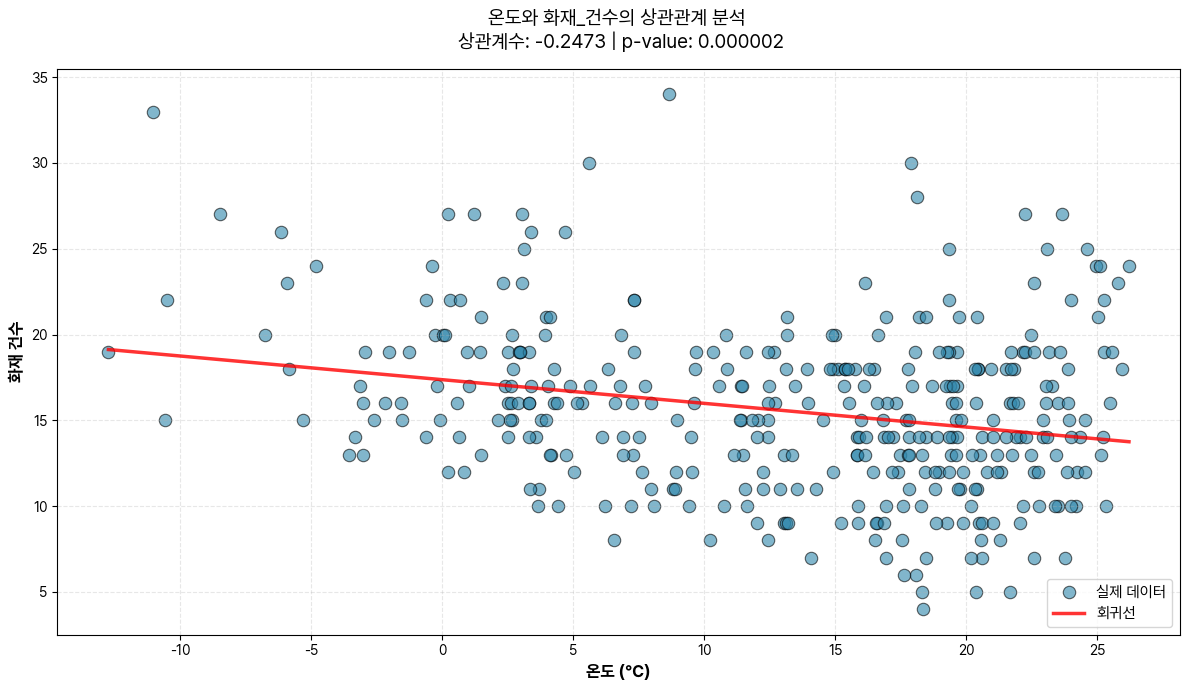

In [36]:
# 온도와 화재_건수의 상관관계 분석
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False


print("="*70)
print("온도와 화재_건수의 상관관계 분석")
print("="*70)

# 데이터 로드
df_merged_final = pd.read_csv('./filtered_data/fire_weather_merged_365.csv', encoding='utf-8')

# 온도와 화재 건수 간의 피어슨 상관계수 및 p-value
correlation_temp, p_value_temp = stats.pearsonr(df_merged_final['온도(℃)'], df_merged_final['화재_건수'])

# 스피어만 상관계수 (비모수 검정)
spearman_temp, p_value_spearman_temp = stats.spearmanr(df_merged_final['온도(℃)'], df_merged_final['화재_건수'])

print(f"\n【 피어슨 상관계수 】")
print(f"  상관계수: {correlation_temp:.6f}")
print(f"  p-value: {p_value_temp:.8f}")
print(f"  해석: ", end="")
if p_value_temp < 0.05:
    if correlation_temp > 0:
        print(f"통계적으로 유의미한 양의 상관관계 (p < 0.05)")
    else:
        print(f"통계적으로 유의미한 음의 상관관계 (p < 0.05)")
else:
    print(f"통계적으로 유의미한 상관관계 없음 (p >= 0.05)")

print(f"\n【 스피어만 상관계수 (비모수) 】")
print(f"  상관계수: {spearman_temp:.6f}")
print(f"  p-value: {p_value_spearman_temp:.8f}")

# 선형 회귀 분석
slope_temp, intercept_temp, r_value_temp, p_value_regr_temp, std_err_temp = stats.linregress(
    df_merged_final['온도(℃)'], df_merged_final['화재_건수']
)

print(f"\n【 선형 회귀 분석 】")
print(f"  회귀계수(기울기): {slope_temp:.6f}")
print(f"  절편: {intercept_temp:.6f}")
print(f"  R²: {r_value_temp**2:.6f}")
print(f"  p-value: {p_value_regr_temp:.8f}")
print(f"  표준오차: {std_err_temp:.6f}")
print(f"  회귀식: 화재_건수 = {slope_temp:.4f} × 온도(℃) + {intercept_temp:.4f}")

# 산점도 및 회귀선 시각화
fig, ax = plt.subplots(figsize=(12, 7))

# 산점도
ax.scatter(df_merged_final['온도(℃)'], df_merged_final['화재_건수'], 
          s=80, alpha=0.6, color='#2E86AB', edgecolors='black', linewidth=0.8, label='실제 데이터')

# 회귀선
x_line = np.linspace(df_merged_final['온도(℃)'].min(), df_merged_final['온도(℃)'].max(), 100)
y_line = slope_temp * x_line + intercept_temp
ax.plot(x_line, y_line, 'r-', linewidth=2.5, label='회귀선', alpha=0.8)

ax.set_xlabel('온도 (℃)', fontsize=12, fontweight='bold')
ax.set_ylabel('화재 건수', fontsize=12, fontweight='bold')
ax.set_title(f'온도와 화재_건수의 상관관계 분석 \n 상관계수: {correlation_temp:.4f} | p-value: {p_value_temp:.6f}', fontsize=14, pad=15)
# ax.text(0.5, 1.05, f'상관계수: {correlation_temp:.4f} | p-value: {p_value_temp:.6f}',
#        transform=ax.transAxes, fontsize=11, ha='center', style='italic')
# ax.text(0.5, 1.00, f'회귀계수: {slope_temp:.4f} | R²: {r_value_temp**2:.4f}',
#        transform=ax.transAxes, fontsize=11, ha='center', style='italic')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='lower right')

plt.tight_layout()
plt.savefig('./results/temperature_fire_correlation.png', dpi=300, bbox_inches='tight')
print(f"\n✓ 그래프 저장: ./results/temperature_fire_correlation.png")
plt.show()

print("\n" + "="*70)

습도와 화재_건수의 상관관계 분석

【 피어슨 상관계수 】
  상관계수: -0.418306
  p-value: 0.00000000
  해석: 통계적으로 유의미한 음의 상관관계 (p < 0.05)

【 스피어만 상관계수 (비모수) 】
  상관계수: -0.411260
  p-value: 0.00000000

【 선형 회귀 분석 】
  회귀계수(기울기): -0.127290
  절편: 23.550411
  R²: 0.174980
  p-value: 0.00000000
  표준오차: 0.014507
  회귀식: 화재_건수 = -0.1273 × 습도(%) + 23.5504

✓ 그래프 저장: ./results/humidity_fire_correlation.png

✓ 그래프 저장: ./results/humidity_fire_correlation.png


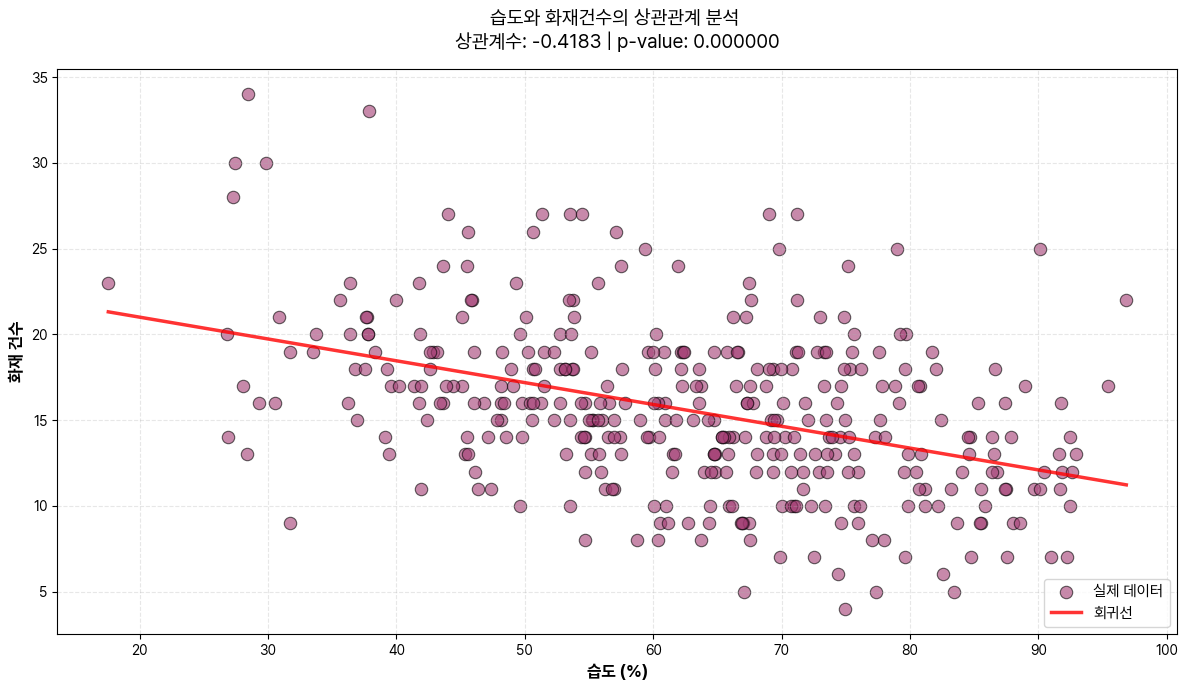

In [35]:
# 습도와 화재_건수의 상관관계 분석
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

print("="*70)
print("습도와 화재_건수의 상관관계 분석")
print("="*70)

# 데이터 로드
df_merged_final = pd.read_csv('./filtered_data/fire_weather_merged_365.csv', encoding='utf-8')

# 습도와 화재 건수 간의 피어슨 상관계수 및 p-value
correlation_humid, p_value_humid = stats.pearsonr(df_merged_final['습도(%)'], df_merged_final['화재_건수'])

# 스피어만 상관계수 (비모수 검정)
spearman_humid, p_value_spearman_humid = stats.spearmanr(df_merged_final['습도(%)'], df_merged_final['화재_건수'])

print(f"\n【 피어슨 상관계수 】")
print(f"  상관계수: {correlation_humid:.6f}")
print(f"  p-value: {p_value_humid:.8f}")
print(f"  해석: ", end="")
if p_value_humid < 0.05:
    if correlation_humid > 0:
        print(f"통계적으로 유의미한 양의 상관관계 (p < 0.05)")
    else:
        print(f"통계적으로 유의미한 음의 상관관계 (p < 0.05)")
else:
    print(f"통계적으로 유의미한 상관관계 없음 (p >= 0.05)")

print(f"\n【 스피어만 상관계수 (비모수) 】")
print(f"  상관계수: {spearman_humid:.6f}")
print(f"  p-value: {p_value_spearman_humid:.8f}")

# 선형 회귀 분석
slope_humid, intercept_humid, r_value_humid, p_value_regr_humid, std_err_humid = stats.linregress(
    df_merged_final['습도(%)'], df_merged_final['화재_건수']
)

print(f"\n【 선형 회귀 분석 】")
print(f"  회귀계수(기울기): {slope_humid:.6f}")
print(f"  절편: {intercept_humid:.6f}")
print(f"  R²: {r_value_humid**2:.6f}")
print(f"  p-value: {p_value_regr_humid:.8f}")
print(f"  표준오차: {std_err_humid:.6f}")
print(f"  회귀식: 화재_건수 = {slope_humid:.4f} × 습도(%) + {intercept_humid:.4f}")

# 산점도 및 회귀선 시각화
fig, ax = plt.subplots(figsize=(12, 7))

# 산점도
ax.scatter(df_merged_final['습도(%)'], df_merged_final['화재_건수'], 
          s=80, alpha=0.6, color='#A23B72', edgecolors='black', linewidth=0.8, label='실제 데이터')

# 회귀선
x_line = np.linspace(df_merged_final['습도(%)'].min(), df_merged_final['습도(%)'].max(), 100)
y_line = slope_humid * x_line + intercept_humid
ax.plot(x_line, y_line, 'r-', linewidth=2.5, label='회귀선', alpha=0.8)

# 통계값 텍스트 박스 제거 - 보조 제목으로 표시

ax.set_xlabel('습도 (%)', fontsize=12, fontweight='bold')
ax.set_ylabel('화재 건수', fontsize=12, fontweight='bold')
ax.set_title(f'습도와 화재건수의 상관관계 분석 \n상관계수: {correlation_humid:.4f} | p-value: {p_value_humid:.6f}', fontsize=14, pad=15)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='lower right')

plt.tight_layout()
plt.savefig('./results/humidity_fire_correlation.png', dpi=300, bbox_inches='tight')
print(f"\n✓ 그래프 저장: ./results/humidity_fire_correlation.png")
plt.show()

print("\n" + "="*70)

화재_건수와 온도, 습도의 다중회귀 분석

【 회귀 계수 】
  절편: 23.490536
  온도(℃) 계수: -0.048975
  습도(%) 계수: -0.116127

【 회귀식 】
  화재_건수 = 23.4905 + -0.0490 × 온도(℃) + -0.1161 × 습도(%)

【 모델 성능 지표 】
  R² (결정계수): 0.181332
  조정 R² (Adjusted R²): 0.176809
  RMSE (평균제곱근오차): 4.407710

【 회귀 계수의 통계적 유의성 】
  절편:
    t-값: 25.044036, p-value: 0.00000000
  온도(℃):
    t-값: -1.676020, p-value: 0.09459764
    해석: 유의미하지 않음 ✗
  습도(%):
    t-값: -7.289714, p-value: 0.00000000
    해석: 유의미 ✓

【 변수 간 상관계수 】
          화재_건수     온도(℃)     습도(%)
화재_건수  1.000000 -0.247297 -0.418306
온도(℃) -0.247297  1.000000  0.418101
습도(%) -0.418306  0.418101  1.000000

✓ 진단 그래프 저장: ./results/multiple_regression_diagnostics.png

✓ 진단 그래프 저장: ./results/multiple_regression_diagnostics.png


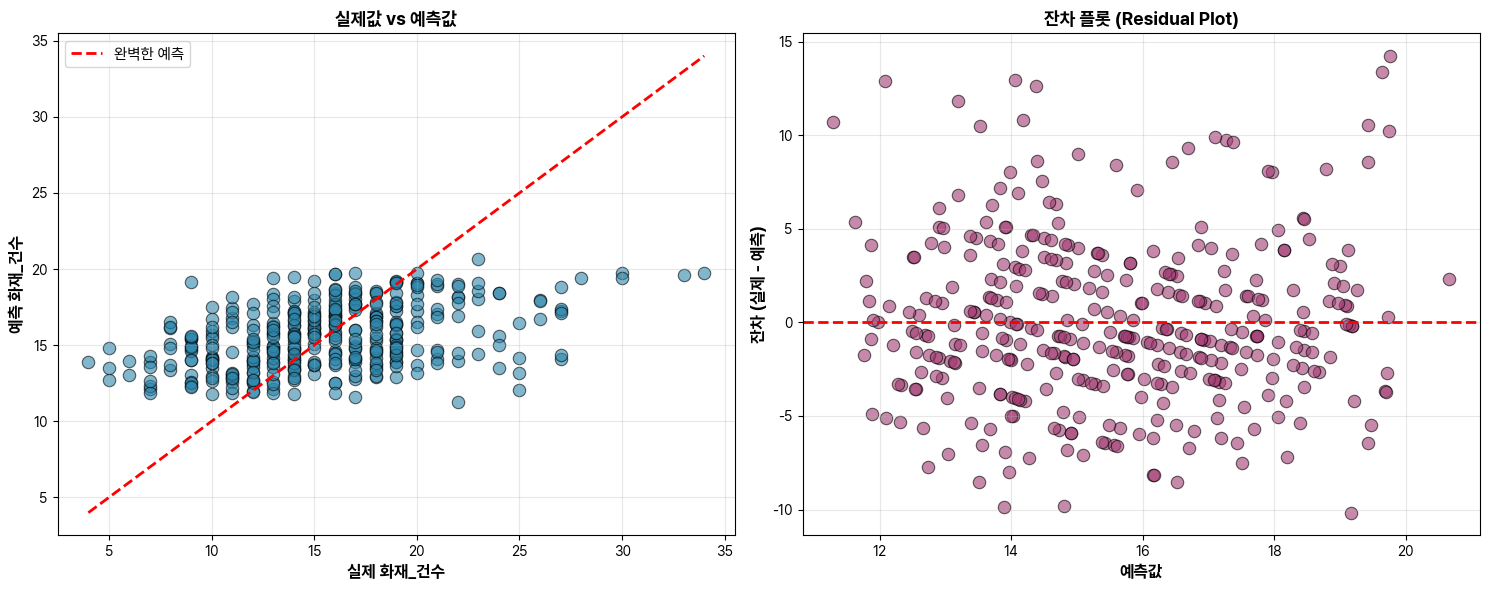

✓ 3D 플롯 저장: ./results/multiple_regression_3d.png


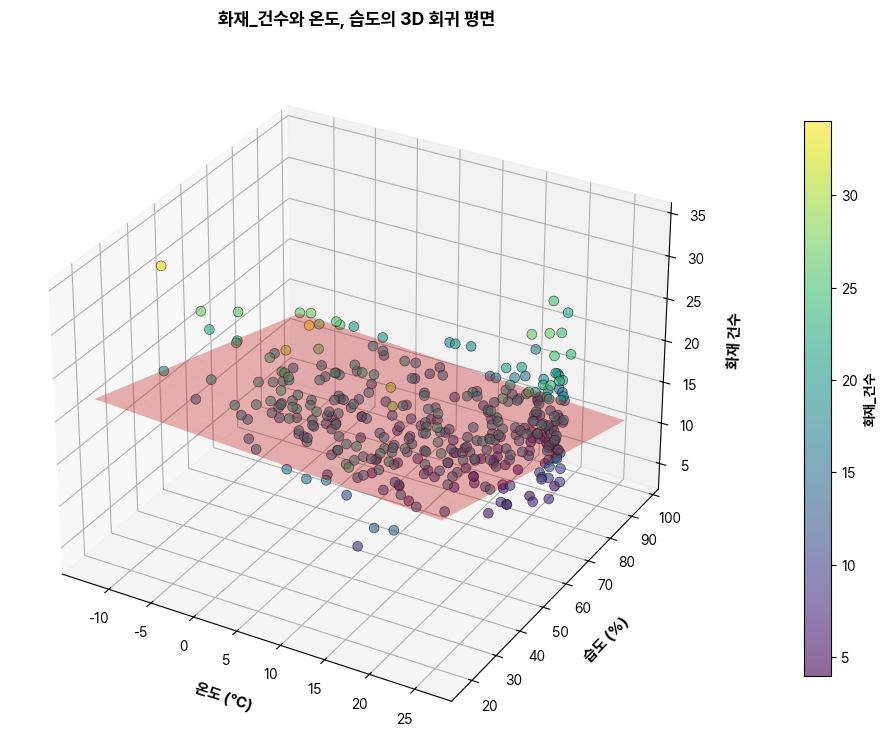


✓ 회귀분석 결과 저장: ./results/multiple_regression_summary.csv

✓ 다중회귀 분석 완료!


In [28]:
# 화재_건수와 온도, 습도의 다중회귀 분석
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
# 한글 폰트 설정
plt.rcParams['font.family'] = 'Pretendard'
plt.rcParams['axes.unicode_minus'] = False

print("="*70)
print("화재_건수와 온도, 습도의 다중회귀 분석")
print("="*70)

# 데이터 로드
df_merged_final = pd.read_csv('./filtered_data/fire_weather_merged_365.csv', encoding='utf-8')

# 독립변수(X)와 종속변수(y) 준비
X = df_merged_final[['온도(℃)', '습도(%)']].values
y = df_merged_final['화재_건수'].values

# 다중회귀 모델 구성
model = LinearRegression()
model.fit(X, y)

# 예측값
y_pred = model.predict(X)

# 성능 지표
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
adj_r2 = 1 - (1 - r2) * (len(y) - 1) / (len(y) - X.shape[1] - 1)

print(f"\n【 회귀 계수 】")
print(f"  절편: {model.intercept_:.6f}")
print(f"  온도(℃) 계수: {model.coef_[0]:.6f}")
print(f"  습도(%) 계수: {model.coef_[1]:.6f}")

print(f"\n【 회귀식 】")
print(f"  화재_건수 = {model.intercept_:.4f} + {model.coef_[0]:.4f} × 온도(℃) + {model.coef_[1]:.4f} × 습도(%)")

print(f"\n【 모델 성능 지표 】")
print(f"  R² (결정계수): {r2:.6f}")
print(f"  조정 R² (Adjusted R²): {adj_r2:.6f}")
print(f"  RMSE (평균제곱근오차): {rmse:.6f}")

# 각 계수의 통계적 유의성 검증 (t-test)
# 수동 계산: t = 계수 / 표준오차
n = len(y)
p = X.shape[1]
residuals = y - y_pred
mse_residuals = np.sum(residuals**2) / (n - p - 1)

# 표준오차 계산
X_with_intercept = np.column_stack([np.ones(n), X])
var_covar_matrix = mse_residuals * np.linalg.inv(X_with_intercept.T @ X_with_intercept)
std_errors = np.sqrt(np.diag(var_covar_matrix))

# 계수들 (절편 포함)
coefs_all = np.insert(model.coef_, 0, model.intercept_)
t_stats = coefs_all / std_errors
p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), n - p - 1))

print(f"\n【 회귀 계수의 통계적 유의성 】")
print(f"  절편:")
print(f"    t-값: {t_stats[0]:.6f}, p-value: {p_values[0]:.8f}")
print(f"  온도(℃):")
print(f"    t-값: {t_stats[1]:.6f}, p-value: {p_values[1]:.8f}")
print(f"    해석: ", end="")
print("유의미 ✓" if p_values[1] < 0.05 else "유의미하지 않음 ✗")
print(f"  습도(%):")
print(f"    t-값: {t_stats[2]:.6f}, p-value: {p_values[2]:.8f}")
print(f"    해석: ", end="")
print("유의미 ✓" if p_values[2] < 0.05 else "유의미하지 않음 ✗")

# 상관행렬
print(f"\n【 변수 간 상관계수 】")
corr_matrix = df_merged_final[['화재_건수', '온도(℃)', '습도(%)']].corr()
print(corr_matrix.to_string())

# 실제값 vs 예측값 비교 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. 실제값 vs 예측값 산점도
ax1 = axes[0]
ax1.scatter(y, y_pred, s=80, alpha=0.6, color='#2E86AB', edgecolors='black', linewidth=0.8)
# 완벽한 예측선
min_val = min(y.min(), y_pred.min())
max_val = max(y.max(), y_pred.max())
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='완벽한 예측')
ax1.set_xlabel('실제 화재_건수', fontsize=12, fontweight='bold')
ax1.set_ylabel('예측 화재_건수', fontsize=12, fontweight='bold')
ax1.set_title('실제값 vs 예측값', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# 2. 잔차(Residuals) 플롯
ax2 = axes[1]
residuals = y - y_pred
ax2.scatter(y_pred, residuals, s=80, alpha=0.6, color='#A23B72', edgecolors='black', linewidth=0.8)
ax2.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax2.set_xlabel('예측값', fontsize=12, fontweight='bold')
ax2.set_ylabel('잔차 (실제 - 예측)', fontsize=12, fontweight='bold')
ax2.set_title('잔차 플롯 (Residual Plot)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./results/multiple_regression_diagnostics.png', dpi=300, bbox_inches='tight')
print(f"\n✓ 진단 그래프 저장: ./results/multiple_regression_diagnostics.png")
plt.show()

# 3. 3D 시각화 (온도, 습도, 화재건수 + 회귀 평면)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(13, 9))
ax = fig.add_subplot(111, projection='3d')

# 실제 데이터
scatter = ax.scatter(df_merged_final['온도(℃)'], df_merged_final['습도(%)'], df_merged_final['화재_건수'],
                    c=df_merged_final['화재_건수'], cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

# 회귀 평면
temp_range = np.linspace(df_merged_final['온도(℃)'].min(), df_merged_final['온도(℃)'].max(), 20)
humid_range = np.linspace(df_merged_final['습도(%)'].min(), df_merged_final['습도(%)'].max(), 20)
temp_mesh, humid_mesh = np.meshgrid(temp_range, humid_range)
fire_mesh = model.intercept_ + model.coef_[0] * temp_mesh + model.coef_[1] * humid_mesh

ax.plot_surface(temp_mesh, humid_mesh, fire_mesh, alpha=0.3, color='red', label='회귀 평면')

ax.set_xlabel('온도 (℃)', fontsize=11, fontweight='bold', labelpad=10)
ax.set_ylabel('습도 (%)', fontsize=11, fontweight='bold', labelpad=10)
ax.set_zlabel('화재 건수', fontsize=11, fontweight='bold', labelpad=10)
ax.set_title('화재_건수와 온도, 습도의 3D 회귀 평면', fontsize=13, fontweight='bold', pad=20)

# 컬러바
cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('화재_건수', fontweight='bold')

plt.savefig('./results/multiple_regression_3d.png', dpi=300, bbox_inches='tight')
print(f"✓ 3D 플롯 저장: ./results/multiple_regression_3d.png")
plt.show()

# 결과 저장
regression_summary = pd.DataFrame({
    '항목': ['절편', '온도(℃) 계수', '습도(%) 계수', 'R²', '조정 R²', 'RMSE'],
    '값': [model.intercept_, model.coef_[0], model.coef_[1], r2, adj_r2, rmse]
})
regression_summary.to_csv('./results/multiple_regression_summary.csv', index=False, encoding='utf-8')
print(f"\n✓ 회귀분석 결과 저장: ./results/multiple_regression_summary.csv")

print("\n" + "="*70)
print("✓ 다중회귀 분석 완료!")
print("="*70)